In [1]:
import json
from typing import List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from rich import print
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image

from src.blip_modules.blip_text_encoder import BLIPTextEncoder
from src.blip_modules.blip_img_encoder import BLIPImgEncoder
from src.data_utils import FashionIQDataset, targetpad_transform
from src.combiner import Combiner
from src.utils import extract_index_features, device, extract_index_features_with_text_captions
from src.validate import generate_fiq_val_predictions

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Modify the function for calculation in different alpha values</div>

# <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform alpha search for the best alpha value after the search and index were encoded</div>

In [2]:
def compute_fiq_val_metrics_text_image_modified(
    relative_val_dataset: FashionIQDataset,
    blip_text_encoder: torch.nn.Module,
    multiple_text_index_features: List[torch.tensor],
    multiple_text_index_names: List[List[str]],
    image_index_features: torch.tensor,
    image_index_names: List[str],
    combining_function: callable
) -> pd.DataFrame:
    """
    Compute validation metrics on FashionIQ dataset combining text and image distances.

    :param relative_val_dataset: FashionIQ validation dataset in relative mode
    :param blip_text_encoder: BLIP model
    :param multiple_text_index_features: validation index features from text
    :param multiple_text_index_names: validation index names from text
    :param image_index_features: validation image index features
    :param image_index_names: validation image index names
    :param combining_function: function that combines features
    :return: the computed validation metrics
    """
    all_text_distances = []
    results = []
    alphas = np.arange(0, 1.05, 0.05)
    target_names = None

    # Compute distances for individual text features
    for text_features, text_names in zip(multiple_text_index_features, multiple_text_index_names):
        # Generate text predictions and normalize features
        predicted_text_features, target_names = generate_fiq_val_predictions(
            blip_text_encoder, relative_val_dataset,
            combining_function, text_names, text_features)
        # Normalize features
        text_features = F.normalize(text_features, dim=-1)
        predicted_text_features = F.normalize(predicted_text_features, dim=-1)

        # Compute cosine similarity and convert to distance
        cosine_similarities = torch.mm(predicted_text_features, text_features.T)
        distances = 1 - cosine_similarities
        all_text_distances.append(distances)

    # Normalize and compute distances for image features if available
    if image_index_features is not None and len(image_index_features) > 0:
        predicted_image_features, _ = generate_fiq_val_predictions(blip_text_encoder, relative_val_dataset,
                                                                   combining_function, image_index_names,
                                                                   image_index_features)

        # Normalize and compute distances
        image_index_features = F.normalize(image_index_features, dim=-1).float()
        image_distances = 1 - predicted_image_features @ image_index_features.T
    else:
        image_distances = torch.zeros_like(all_text_distances[0])

    # Merge text distances
    merged_text_distances = torch.mean(torch.stack(all_text_distances), dim=0)

    # Iterating over alpha values
    for alpha in alphas:
        merged_distances = alpha * merged_text_distances + (1 - alpha) * image_distances
        sorted_indices = torch.argsort(merged_distances, dim=-1).cpu()
        sorted_index_names = np.array(image_index_names if image_index_names else multiple_text_index_names[0])[
            sorted_indices]
        labels = torch.tensor(
            sorted_index_names == np.repeat(np.array(target_names), len(sorted_index_names[0])).reshape(
                len(target_names), -1))
        assert torch.equal(torch.sum(labels, dim=-1).int(), torch.ones(len(target_names)).int())
        recall_at10 = (torch.sum(labels[:, :10]) / len(labels)).item() * 100
        recall_at50 = (torch.sum(labels[:, :50]) / len(labels)).item() * 100
        results.append({"alpha": alpha, "recall_at10": recall_at10, "recall_at50": recall_at50})

    return pd.DataFrame(results)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">The only diffence is remove alpha parameter from the function</div>

In [3]:
def fashioniq_val_retrieval_text_image_modified(
    dress_type: str,
    combining_function: callable,
    blip_text_encoder: torch.nn.Module,
    blip_img_encoder: torch.nn.Module,
    text_captions: List[dict],
    preprocess: callable):
    """
    Perform retrieval on FashionIQ validation set computing the metrics. To combine the features the `combining_function`
    is used
    :param dress_type: FashionIQ category on which perform the retrieval
    :param combining_function:function which takes as input (image_features, text_features) and outputs the combined
                            features
    :param blip_text_encoder: BLIP text model
    :param blip_img_encoder: BLIP image model
    :param text_captions: text captions for the FashionIQ dataset
    :param preprocess: preprocess pipeline
    """

    blip_text_encoder = blip_text_encoder.float().eval()
    blip_img_encoder = blip_img_encoder.float().eval()

    # Define the validation datasets and extract the index features
    classic_val_dataset = FashionIQDataset('val', [dress_type], 'classic', preprocess)

    multiple_index_features, multiple_index_names = [], []

    for i in range(3):
        index_features, index_names, _ = extract_index_features_with_text_captions(
            classic_val_dataset,
            blip_text_encoder,
            text_captions,
            i + 1
        )
        multiple_index_features.append(index_features)
        multiple_index_names.append(index_names)

    image_index_features, image_index_names = extract_index_features(classic_val_dataset, blip_img_encoder)

    relative_val_dataset = FashionIQDataset('val', [dress_type], 'relative', preprocess)

    return compute_fiq_val_metrics_text_image_modified(
        relative_val_dataset,
        blip_text_encoder,
        multiple_index_features,
        multiple_index_names,
        image_index_features,
        image_index_names,
        combining_function
    )

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the BLIP model and the Combiner</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [4]:
BLIP_PRETRAINED_PATH = '../models/model_base.pth'
MED_CONFIG_PATH = 'blip_modules/med_config.json'

In [5]:
blip_text_encoder = BLIPTextEncoder(
    BLIP_PRETRAINED_PATH, 
    MED_CONFIG_PATH,
    use_pretrained_proj_layer=True
)

blip_text_encoder = blip_text_encoder.to(device)
print("blip text encoder loaded.")
blip_text_encoder.eval()

load checkpoint from ../models/model_base.pth for text_encoder.
load checkpoint from ../models/model_base.pth for text_proj.


blip text encoder loaded.

BLIPTextEncoder(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Drop

In [6]:
blip_img_encoder = BLIPImgEncoder(BLIP_PRETRAINED_PATH)
blip_img_encoder = blip_img_encoder.to(device)
print("blip img encoder loaded.")
blip_img_encoder = blip_img_encoder.eval()

reshape position embedding from 196 to 576
load checkpoint from ../models/model_base.pth for visual_encoder.
load checkpoint from ../models/model_base.pth for vision_proj.


blip img encoder loaded.

In [7]:
print('Target pad preprocess pipeline is used')
preprocess = targetpad_transform(1.25, 384)

Target pad preprocess pipeline is used

In [8]:
def element_wise_sum(image_features: torch.tensor, text_features: torch.tensor) -> torch.tensor:
    """
    Normalized element-wise sum of image features and text features
    :param image_features: non-normalized image features
    :param text_features: non-normalized text features
    :return: normalized element-wise sum of image and text features
    """
    return F.normalize(image_features + text_features, dim=-1)

In [9]:
combining_function = element_wise_sum

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions and perform retrieval on the FashionIQ dataset</div>

In [10]:
average_recall_list: List[pd.DataFrame] = []

with open('../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [11]:
shirt_recall = fashioniq_val_retrieval_text_image_modified(
    'shirt',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess
)
average_recall_list.append(shirt_recall)

shirt_recall

FashionIQ val - ['shirt'] dataset in classic mode initialized


100%|██████████| 199/199 [00:54<00:00,  3.65it/s]

FashionIQ val - ['shirt'] dataset in relative mode initialized


[2024-05-02 02:54:14.537276] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 57.47it/s]


[2024-05-02 02:54:15.662801] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 60.06it/s]


[2024-05-02 02:54:16.735958] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 60.68it/s]


[2024-05-02 02:54:17.798700] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 59.80it/s]


alpha  recall_at10  recall_at50
0    0.00     8.243376    18.302257
1    0.05     8.783121    18.792935
2    0.10     8.979391    19.528949
3    0.15     9.273798    20.264965
4    0.20     9.911678    20.853779
5    0.25    10.353287    21.393523
6    0.30    10.598626    22.374877
7    0.35    10.942100    23.405299
8    0.40    11.138371    23.945044
9    0.45    11.383709    24.582924
10   0.50    11.334642    25.269872
11   0.55    12.119725    25.907752
12   0.60    12.266929    26.251227
13   0.65    12.365064    26.692837
14   0.70    12.855741    26.692837
15   0.75    12.855741    26.790971
16   0.80    12.904808    26.545632
17   0.85    12.414131    25.809616
18   0.90    11.923455    25.220805
19   0.95    11.776251    23.846909
20   1.00    11.727183    23.356232

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [12]:
dress_recall = fashioniq_val_retrieval_text_image_modified(
    'dress',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess
)
average_recall_list.append(dress_recall)
dress_recall

FashionIQ val - ['dress'] dataset in classic mode initialized


100%|██████████| 120/120 [00:33<00:00,  3.61it/s]

FashionIQ val - ['dress'] dataset in relative mode initialized


[2024-05-02 02:55:20.739572] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 56.72it/s]


[2024-05-02 02:55:21.874654] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 56.81it/s]


[2024-05-02 02:55:23.007378] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 56.89it/s]


[2024-05-02 02:55:24.138282] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 57.16it/s]


alpha  recall_at10  recall_at50
0    0.00     5.156172    13.386217
1    0.05     5.007437    13.832425
2    0.10     5.304908    14.278631
3    0.15     5.503223    14.625682
4    0.20     5.552801    14.724839
5    0.25     5.651958    15.468517
6    0.30     5.751115    16.261774
7    0.35     5.651958    16.311353
8    0.40     5.503223    16.559246
9    0.45     5.503223    16.360933
10   0.50     5.304908    16.410510
11   0.55     5.255330    16.807139
12   0.60     5.304908    16.559246
13   0.65     5.255330    16.360933
14   0.70     5.057015    16.013882
15   0.75     4.858701    15.022311
16   0.80     4.908280    14.625682
17   0.85     4.858701    13.931581
18   0.90     4.462072    13.039167
19   0.95     4.362915    12.295488
20   1.00     3.668815    11.650967

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [13]:
toptee_recall = fashioniq_val_retrieval_text_image_modified(
    'toptee',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess
)
average_recall_list.append(toptee_recall)
toptee_recall

FashionIQ val - ['toptee'] dataset in classic mode initialized


100%|██████████| 168/168 [00:46<00:00,  3.62it/s]

FashionIQ val - ['toptee'] dataset in relative mode initialized


[2024-05-02 02:56:48.201956] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 52.80it/s]


[2024-05-02 02:56:49.384226] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 57.79it/s]


[2024-05-02 02:56:50.464013] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 57.78it/s]


[2024-05-02 02:56:51.544396] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 58.03it/s]


alpha  recall_at10  recall_at50
0    0.00     7.343192    17.032127
1    0.05     7.445181    17.644060
2    0.10     7.802141    18.459970
3    0.15     7.955125    19.428863
4    0.20     8.363080    20.142785
5    0.25     8.873024    21.315655
6    0.30     9.331974    22.029577
7    0.35     9.790923    23.406425
8    0.40    10.096889    24.120347
9    0.45    10.555839    24.936257
10   0.50    11.167771    26.211116
11   0.55    11.269760    26.721060
12   0.60    12.187659    27.129015
13   0.65    12.646610    27.282000
14   0.70    11.983681    27.485976
15   0.75    12.544620    27.332994
16   0.80    12.238654    27.383989
17   0.85    11.932687    26.823050
18   0.90    11.218766    26.364100
19   0.95    10.810811    25.497195
20   1.00    10.402856    24.222335

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories</div>

In [14]:
average_recall = pd.DataFrame(
    {
        "alpha": dress_recall["alpha"],
        "recall_at10": np.mean([shirt_recall["recall_at10"], dress_recall["recall_at10"], toptee_recall["recall_at10"]], axis=0),
        "recall_at50": np.mean([shirt_recall["recall_at50"], dress_recall["recall_at50"], toptee_recall["recall_at50"]], axis=0)
    }
)
average_recall

alpha  recall_at10  recall_at50
0    0.00     6.914247    16.240200
1    0.05     7.078580    16.756473
2    0.10     7.362147    17.422517
3    0.15     7.577382    18.106503
4    0.20     7.942520    18.573801
5    0.25     8.292756    19.392565
6    0.30     8.560572    20.222076
7    0.35     8.794994    21.041026
8    0.40     8.912827    21.541546
9    0.45     9.147590    21.960038
10   0.50     9.269107    22.630499
11   0.55     9.548272    23.145317
12   0.60     9.919832    23.313163
13   0.65    10.089001    23.445257
14   0.70     9.965479    23.397565
15   0.75    10.086354    23.048759
16   0.80    10.017247    22.851768
17   0.85     9.735173    22.188082
18   0.90     9.201431    21.541358
19   0.95     8.983326    20.546531
20   1.00     8.599618    19.743178

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [15]:
plt.style.use('seaborn-whitegrid')

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the plot function</div>

In [16]:
def plot_recall_at10_and_50(df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 6))
    plt.plot(df["alpha"], df["recall_at10"], label="Recall@10", marker='o')
    plt.plot(df["alpha"], df["recall_at50"], label="Recall@50", marker='o')
    plt.axvline(x=df[df["recall_at10"] == df["recall_at10"].max()]["alpha"].values[0],
                color='r', linestyle='--', label="Best Recall@10")
    plt.axvline(x=df[df["recall_at50"] == df["recall_at50"].max()]["alpha"].values[0],
                color='g', linestyle='--', label="Best Recall@50")

    plt.xlabel("Alpha")
    plt.ylabel("Recall (%)")
    plt.title(title)
    plt.legend()
    plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

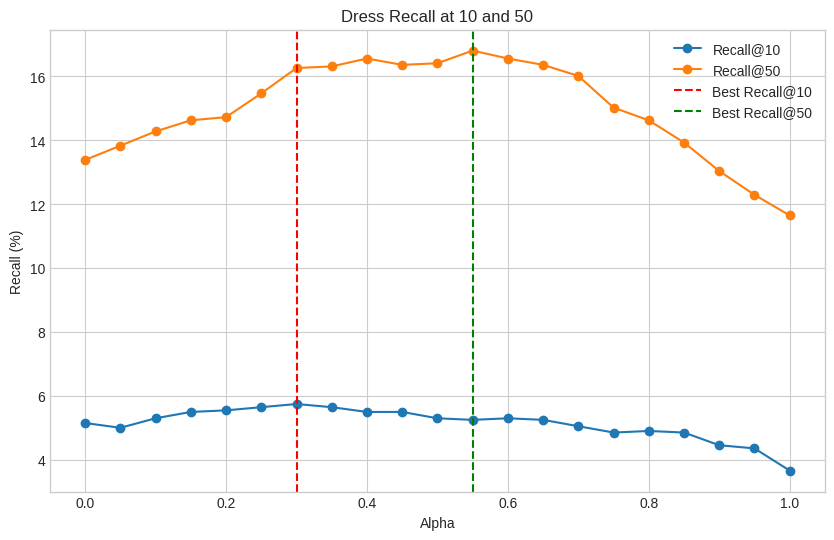

In [17]:
plot_recall_at10_and_50(dress_recall, "Dress Recall at 10 and 50")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

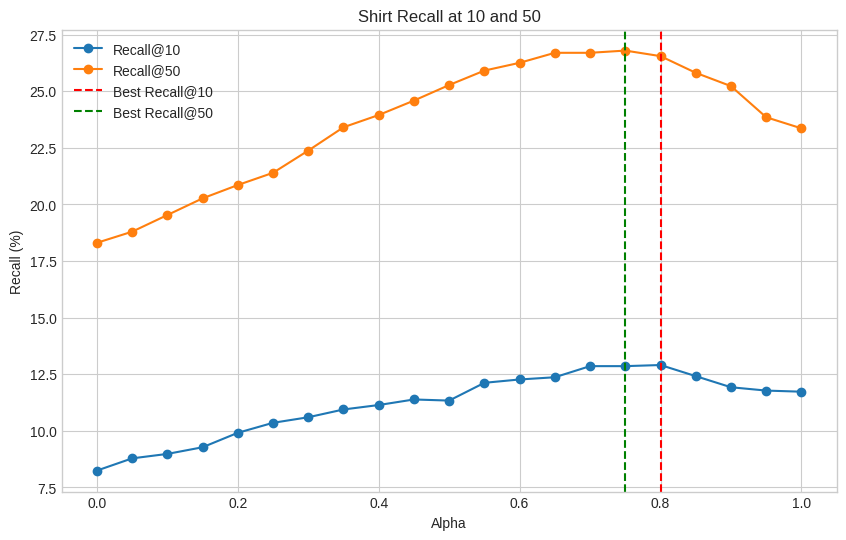

In [18]:
plot_recall_at10_and_50(shirt_recall, "Shirt Recall at 10 and 50")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

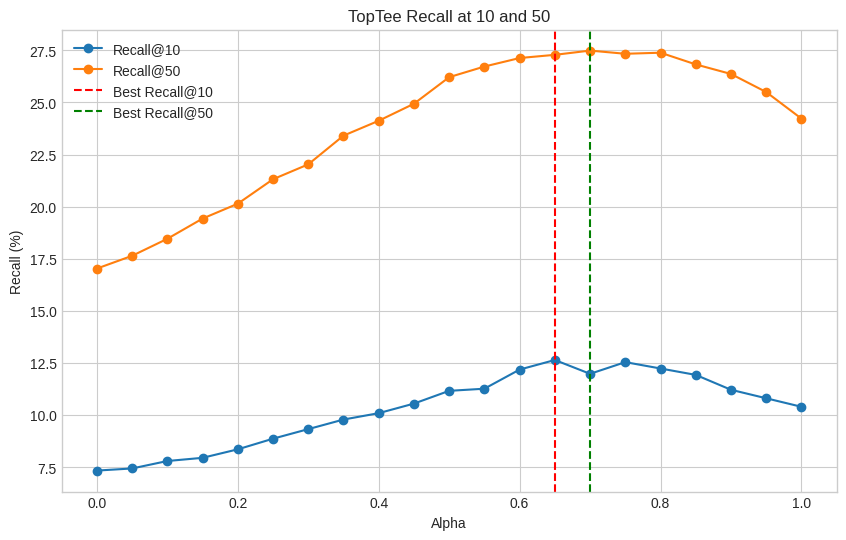

In [19]:
plot_recall_at10_and_50(toptee_recall, "TopTee Recall at 10 and 50")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

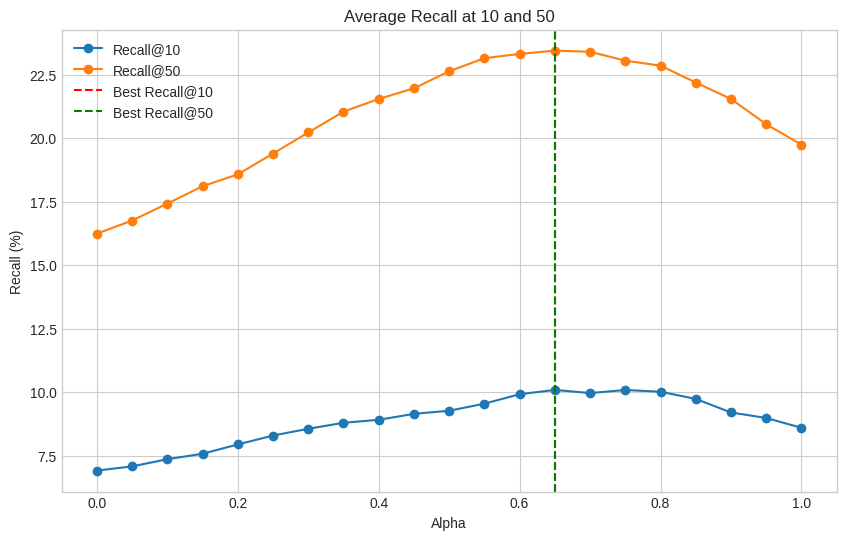

In [20]:
plot_recall_at10_and_50(average_recall, "Average Recall at 10 and 50")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the function to compute the results</div>

In [21]:
def compute_results(
    dress_type: str,
    combining_function: callable,
    blip_text_encoder: torch.nn.Module,
    blip_img_encoder: torch.nn.Module,
    text_captions: List[dict],
    preprocess: callable,
    alpha: float = 0.65
)-> Tuple[torch.tensor, List[str], List[str]]:
    """
    View sample results on FashionIQ dataset combining text and image distances.
    
    :param dress_type: FashionIQ category on which perform the retrieval
    :param combining_function:function which takes as input (image_features, text_features) and outputs the combined
                            features
    :param blip_text_encoder: BLIP text model
    :param blip_img_encoder: BLIP image model
    :param text_captions: text captions for the FashionIQ dataset
    :param preprocess: preprocess pipeline
    :param alpha: alpha value for combining text and image distances
    
    :return: [(image_path, text_caption, candidate_image_paths)]
    """
    blip_text_encoder = blip_text_encoder.float().eval()
    blip_img_encoder = blip_img_encoder.float().eval()
    
    # Define the validation datasets and extract the index features
    classic_val_dataset = FashionIQDataset('val', [dress_type], 'classic', preprocess)
    
    multiple_text_index_features, multiple_text_index_names = [], []
    
    for i in range(3):
        index_features, index_names, _ = extract_index_features_with_text_captions(
            classic_val_dataset,
            blip_text_encoder,
            text_captions,
            i + 1
        )
        multiple_text_index_features.append(index_features)
        multiple_text_index_names.append(index_names)
    
    image_index_features, image_index_names = extract_index_features(classic_val_dataset, blip_img_encoder)
    
    relative_val_dataset = FashionIQDataset('val', [dress_type], 'relative', preprocess)
    
    all_text_distances = []
    
    # Compute distances for individual text features
    for text_features, text_names in zip(multiple_text_index_features, multiple_text_index_names):
        # Generate text predictions and normalize features
        predicted_text_features, target_names = generate_fiq_val_predictions(blip_text_encoder, relative_val_dataset,
                                                                             combining_function, text_names,
                                                                             text_features)
        # Normalize features
        text_features = F.normalize(text_features, dim=-1)
        predicted_text_features = F.normalize(predicted_text_features, dim=-1)

        # Compute cosine similarity and convert to distance
        cosine_similarities = torch.mm(predicted_text_features, text_features.T)
        distances = 1 - cosine_similarities
        all_text_distances.append(distances)

    predicted_image_features, target_names = generate_fiq_val_predictions(blip_text_encoder, relative_val_dataset,
                                                               combining_function, image_index_names,
                                                               image_index_features)

    # Normalize and compute distances
    image_index_features = F.normalize(image_index_features, dim=-1).float()
    image_distances = 1 - predicted_image_features @ image_index_features.T

    # Merge text distances
    merged_text_distances = torch.mean(torch.stack(all_text_distances), dim=0)
    
    merged_distances = alpha * merged_text_distances + (1 - alpha) * image_distances
    
    # Sort the results
    sorted_indices = torch.argsort(merged_distances, dim=-1).cpu()
        
    return sorted_indices, image_index_names, target_names

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [22]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results(
    'dress',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess
)

FashionIQ val - ['dress'] dataset in classic mode initialized


100%|██████████| 120/120 [00:33<00:00,  3.60it/s]

FashionIQ val - ['dress'] dataset in relative mode initialized


[2024-05-02 02:57:55.608137] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 56.08it/s]


[2024-05-02 02:57:56.756096] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 56.36it/s]


[2024-05-02 02:57:57.897591] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 56.17it/s]


[2024-05-02 02:57:59.043082] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 56.27it/s]


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [23]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results(
    'shirt',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess
)

FashionIQ val - ['shirt'] dataset in classic mode initialized


100%|██████████| 199/199 [00:54<00:00,  3.62it/s]

FashionIQ val - ['shirt'] dataset in relative mode initialized


[2024-05-02 02:59:33.065519] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 59.37it/s]


[2024-05-02 02:59:34.151983] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 59.29it/s]


[2024-05-02 02:59:35.337106] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 58.24it/s]


[2024-05-02 02:59:36.444689] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 59.36it/s]


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [24]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results(
    'toptee',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess
)

FashionIQ val - ['toptee'] dataset in classic mode initialized


100%|██████████| 168/168 [00:47<00:00,  3.57it/s]

FashionIQ val - ['toptee'] dataset in relative mode initialized


[2024-05-02 03:00:58.301547] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 52.34it/s]


[2024-05-02 03:00:59.494558] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 55.48it/s]


[2024-05-02 03:01:00.619019] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 56.64it/s]


[2024-05-02 03:01:01.720774] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 57.60it/s]


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [25]:
def prepare_ground_truths(json_data):
    """
    Prepare ground truth data from the JSON structure.
    
    :param json_data: JSON data containing target and candidate matches with captions
    :return: Dictionary mapping targets to lists of tuples (candidates and captions)
    """
    ground_truths = {}
    for entry in json_data:
        target = entry['target']
        candidate = entry['candidate']
        captions = entry['captions']
        if target not in ground_truths:
            ground_truths[target] = []
        ground_truths[target].append((candidate, captions))  # Store as a tuple
    return ground_truths

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the retrieval results for a query</div>

In [26]:
def plot_retrieval_results_of_i(sorted_indices, image_index_names, target_names, ground_truths, top_k=5, i=0):
    """
    Plot retrieval results for a specific query showing the query and its top retrieved images, highlighting ground truths
    and displaying associated captions to the left of the query image.

    :param sorted_indices: 2D tensor or array with sorted indices of retrieved images per query.
    :param image_index_names: List of image paths corresponding to indices in sorted_indices.
    :param target_names: List of names or descriptions for each query.
    :param ground_truths: Dictionary mapping target names to lists of tuples (candidates and captions).
    :param top_k: Number of top retrieved results to display per query.
    :param i: Index of the query to display.
    """
    fig = plt.figure(figsize=(30, 5))
    gs = GridSpec(1, top_k + 2, figure=fig)

    query_index = i
    query_img_path = image_index_names[query_index]
    query_img = Image.open(f'../fashionIQ_dataset/images/{query_img_path}.png')
    
    # Subplot for the caption text to the left of the query image
    ax_text = fig.add_subplot(gs[0, 0])
    query_name = target_names[query_index]
    query_captions = '\n'.join(capt for _, caps in ground_truths.get(query_name, []) for capt in caps)
    ax_text.text(0.5, 0.5, query_captions, va='center', ha='center')
    ax_text.axis('off')

    # Subplot for the query image
    ax_image = fig.add_subplot(gs[0, 1])
    ax_image.imshow(query_img)
    ax_image.set_title(f"Query: {query_name}", color='blue')
    ax_image.axis('off')

    top_indices = sorted_indices[i, :top_k]

    for j, idx in enumerate(top_indices, start=0):
        img_path = image_index_names[idx]
        img = Image.open(f'../fashionIQ_dataset/images/{img_path}.png')
        
        ax_result = fig.add_subplot(gs[0, j + 2])  # Starting from the third grid column
        ax_result.imshow(img)

        # Check if this image is a ground truth and retrieve its captions
        image_captions = '\n'.join(capt for cand, caps in ground_truths.get(query_name, []) if cand == img_path for capt in caps)
        if img_path in [cand for cand, _ in ground_truths.get(query_name, [])]:
            ax_result.set_title(f"{img_path}", color='green')
        else:
            ax_result.set_title(img_path)

        ax_result.axis('off')

    plt.tight_layout()
    plt.show()

In [27]:
ground_truth_dress = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.toptee.val.json')))

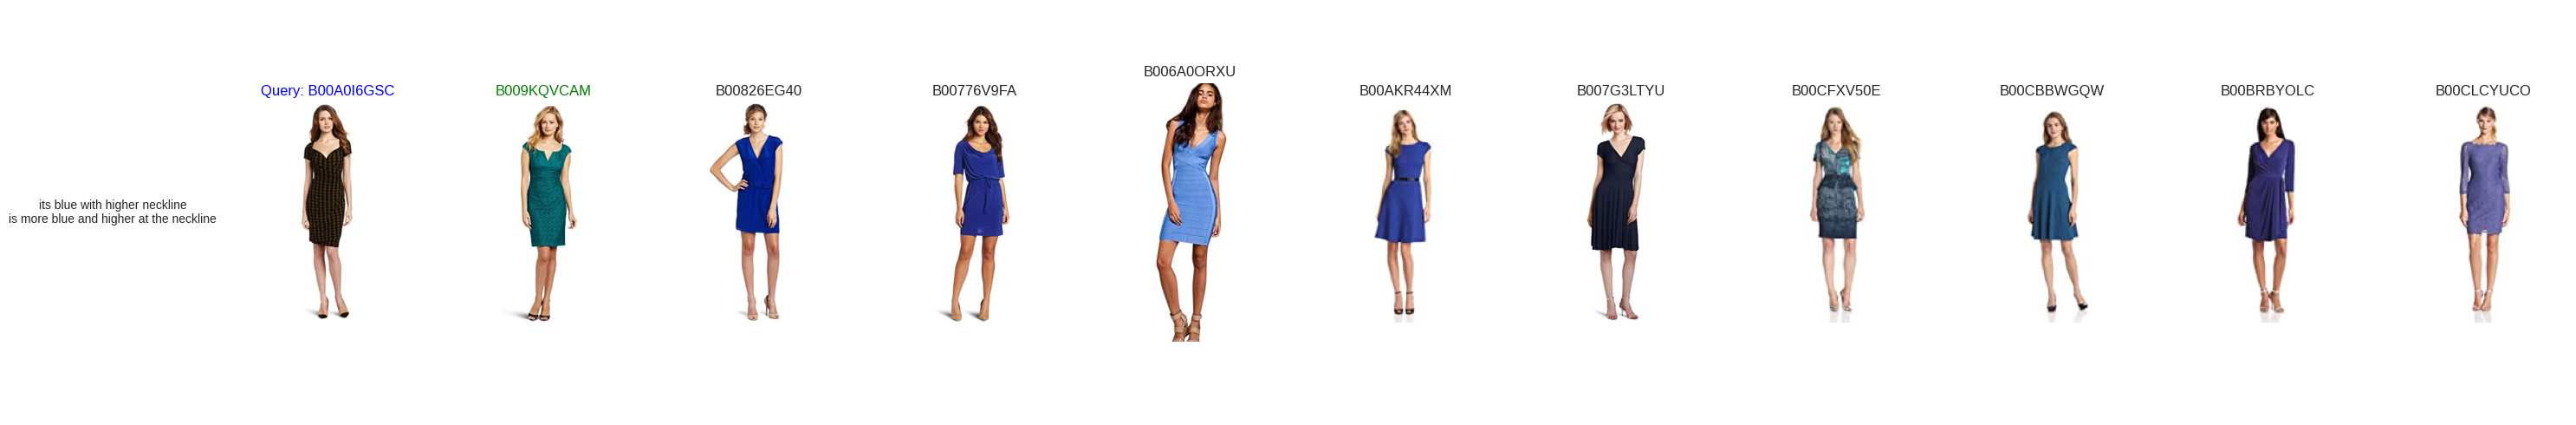

In [28]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=10)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with alpha=0 (Same as the original BLIP4CIR)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category with alpha=0</div>

In [29]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results(
    'dress',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['dress'] dataset in classic mode initialized


100%|██████████| 120/120 [00:33<00:00,  3.56it/s]

FashionIQ val - ['dress'] dataset in relative mode initialized


[2024-05-02 03:02:02.169482] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 55.39it/s]


[2024-05-02 03:02:03.331410] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 57.53it/s]


[2024-05-02 03:02:04.449543] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 56.70it/s]


[2024-05-02 03:02:05.584470] Compute FashionIQ ['dress'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 57.58it/s]


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category with alpha=0</div>

In [30]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results(
    'shirt',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['shirt'] dataset in classic mode initialized


100%|██████████| 199/199 [00:55<00:00,  3.56it/s]

FashionIQ val - ['shirt'] dataset in relative mode initialized


[2024-05-02 03:03:43.565589] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 58.61it/s]


[2024-05-02 03:03:44.665642] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 59.17it/s]


[2024-05-02 03:03:45.755505] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 57.64it/s]


[2024-05-02 03:03:46.872907] Compute FashionIQ ['shirt'] validation predictions

100%|██████████| 64/64 [00:01<00:00, 58.85it/s]


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category with alpha=0</div>

In [31]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results(
    'toptee',
    combining_function,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0
)

FashionIQ val - ['toptee'] dataset in classic mode initialized


100%|██████████| 168/168 [00:46<00:00,  3.58it/s]

FashionIQ val - ['toptee'] dataset in relative mode initialized


[2024-05-02 03:05:10.087202] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 49.37it/s]


[2024-05-02 03:05:11.351346] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 53.75it/s]


[2024-05-02 03:05:12.512064] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 42.88it/s]


[2024-05-02 03:05:13.964842] Compute FashionIQ ['toptee'] validation predictions

100%|██████████| 62/62 [00:01<00:00, 54.04it/s]


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results</div>

In [32]:
def found_better_than_original_i(
        sorted_indices_origin, image_index_names_origin, target_names_origin,
        sorted_indices, image_index_names, ground_truth, top_k=10
):
    """
    Return indices of queries where the new retrieval results are better than the original results.
    
    :param sorted_indices_origin: 2D array with sorted indices of retrieved images per query for the original method.
    :param image_index_names_origin: List of image paths corresponding to indices in sorted_indices_origin.
    :param target_names_origin: List of names or descriptions for each query for the original method.
    :param sorted_indices: 2D array with sorted indices of retrieved images per query for the new method.
    :param image_index_names: List of image paths corresponding to indices in sorted_indices.
    :param ground_truth: Dictionary mapping target names to lists of tuples (candidates and captions).
    :param top_k: Number of top retrieved results to consider per query.
    :return: List of indices where the new method outperforms the original method.
    """
    better_indices = []
    total_queries = len(target_names_origin)  # Assuming the same number of queries for both sets

    for i in range(total_queries):
        original_rank = top_k + 1  # Initialize with a rank worse than top_k
        new_rank = top_k + 1

        # Get ground truth candidates for this query
        query_name = target_names_origin[i]
        ground_truth_candidates = [cand for cand, _ in ground_truth.get(query_name, [])]

        # Find the rank of the first ground truth candidate in the original results
        for rank, idx in enumerate(sorted_indices_origin[i, :top_k]):
            if image_index_names_origin[idx] in ground_truth_candidates:
                original_rank = rank
                break

        # Find the rank of the first ground truth candidate in the new results
        for rank, idx in enumerate(sorted_indices[i, :top_k]):
            if image_index_names[idx] in ground_truth_candidates:
                new_rank = rank
                break

        # Compare the ranks; lower is better
        if new_rank < original_rank and new_rank < top_k:
            better_indices.append(i)  # Collect index where new is better

    return better_indices

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [33]:
become_better = found_better_than_original_i(sorted_indices_dress_origin, 
                                             image_index_names_dress_origin,
                                             target_names_dress_origin,
                                             sorted_indices_dress, 
                                             image_index_names_dress,
                                             ground_truth_dress, 10)

len(become_better), become_better[:10]

(32, [45, 67, 253, 288, 316, 535, 562, 572, 600, 755])

In [34]:
become_worse =  found_better_than_original_i(sorted_indices_dress, 
                                             image_index_names_dress, 
                                             target_names_dress,
                                             sorted_indices_dress_origin, 
                                             image_index_names_dress_origin, 
                                             ground_truth_dress, 
                                             top_k=10)

len(become_worse), become_worse[:10]

(0, [])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [35]:
become_better = found_better_than_original_i(sorted_indices_shirt_origin, 
                                             image_index_names_shirt_origin,
                                             target_names_shirt_origin,
                                             sorted_indices_shirt, 
                                             image_index_names_shirt, 
                                             ground_truth_shirt,
                                             top_k=10)

len(become_better), become_better[:10]

(19, [5, 49, 124, 197, 279, 336, 483, 633, 911, 1050])

In [36]:
become_worse = found_better_than_original_i(sorted_indices_shirt, 
                                            image_index_names_shirt, 
                                            target_names_shirt,
                                            sorted_indices_shirt_origin, 
                                            image_index_names_shirt_origin,
                                            ground_truth_shirt,
                                            top_k=10)

len(become_worse), become_worse[:10]

(0, [])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [37]:
become_better = found_better_than_original_i(sorted_indices_toptee_origin, 
                                             image_index_names_toptee_origin,
                                             target_names_toptee_origin,
                                             sorted_indices_toptee, 
                                             image_index_names_toptee,
                                             ground_truth_toptee,
                                             top_k=10)

len(become_better), become_better[:10]

(14, [440, 459, 473, 717, 753, 882, 904, 1043, 1330, 1365])

In [38]:
become_worse = found_better_than_original_i(sorted_indices_toptee, 
                                            image_index_names_toptee, 
                                            target_names_toptee,
                                            sorted_indices_toptee_origin, 
                                            image_index_names_toptee_origin,
                                            ground_truth_toptee,
                                            top_k=10)

len(become_worse), become_worse[:10]

(0, [])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

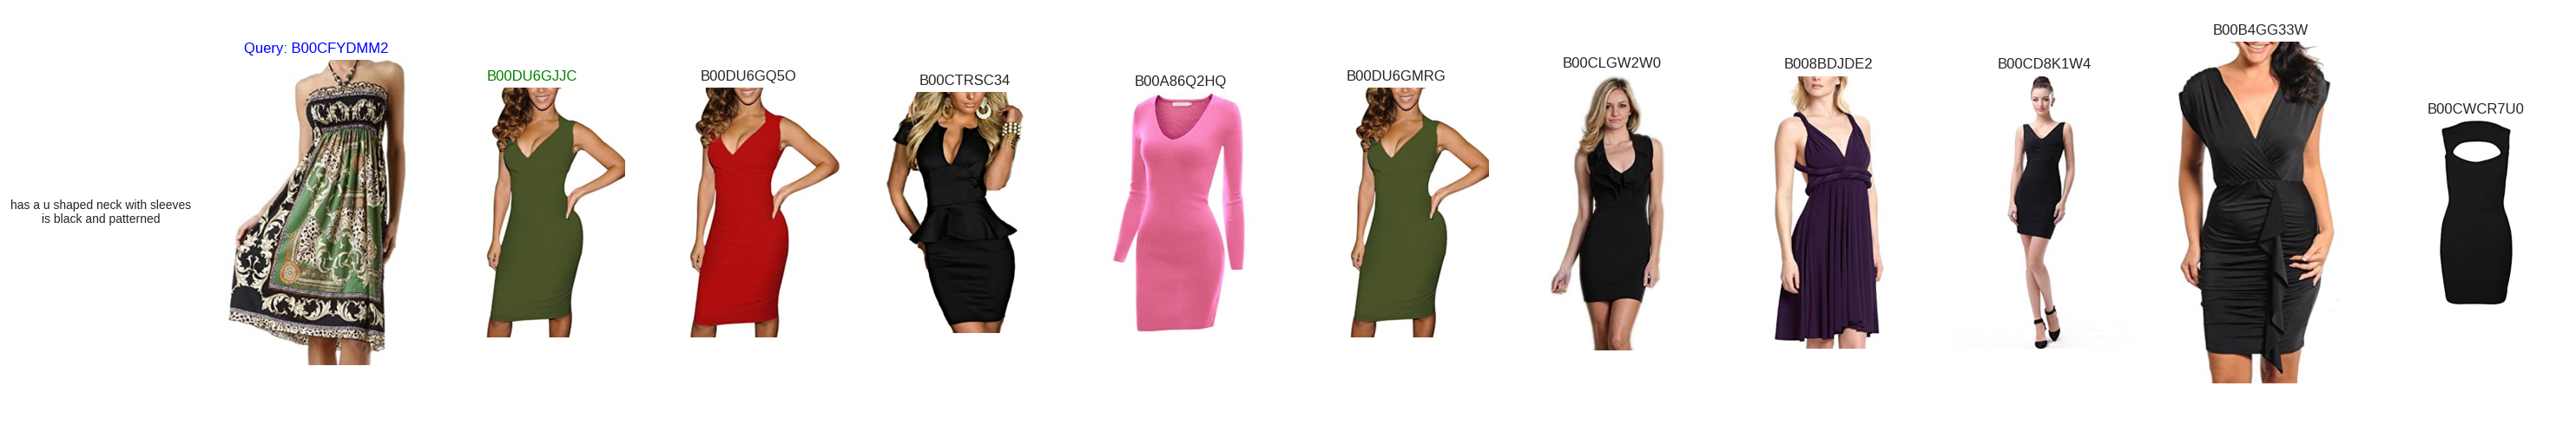

In [39]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=45)

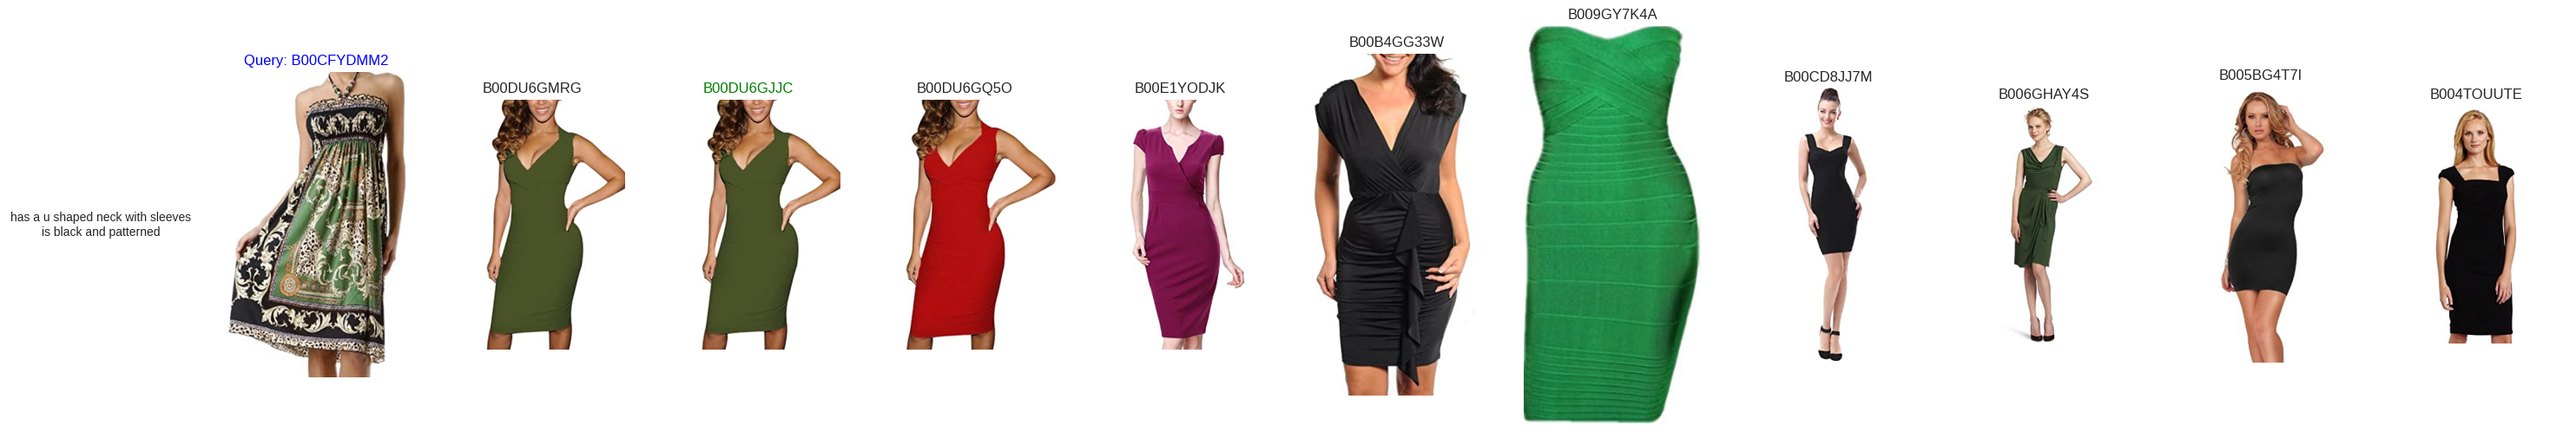

In [40]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=45)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

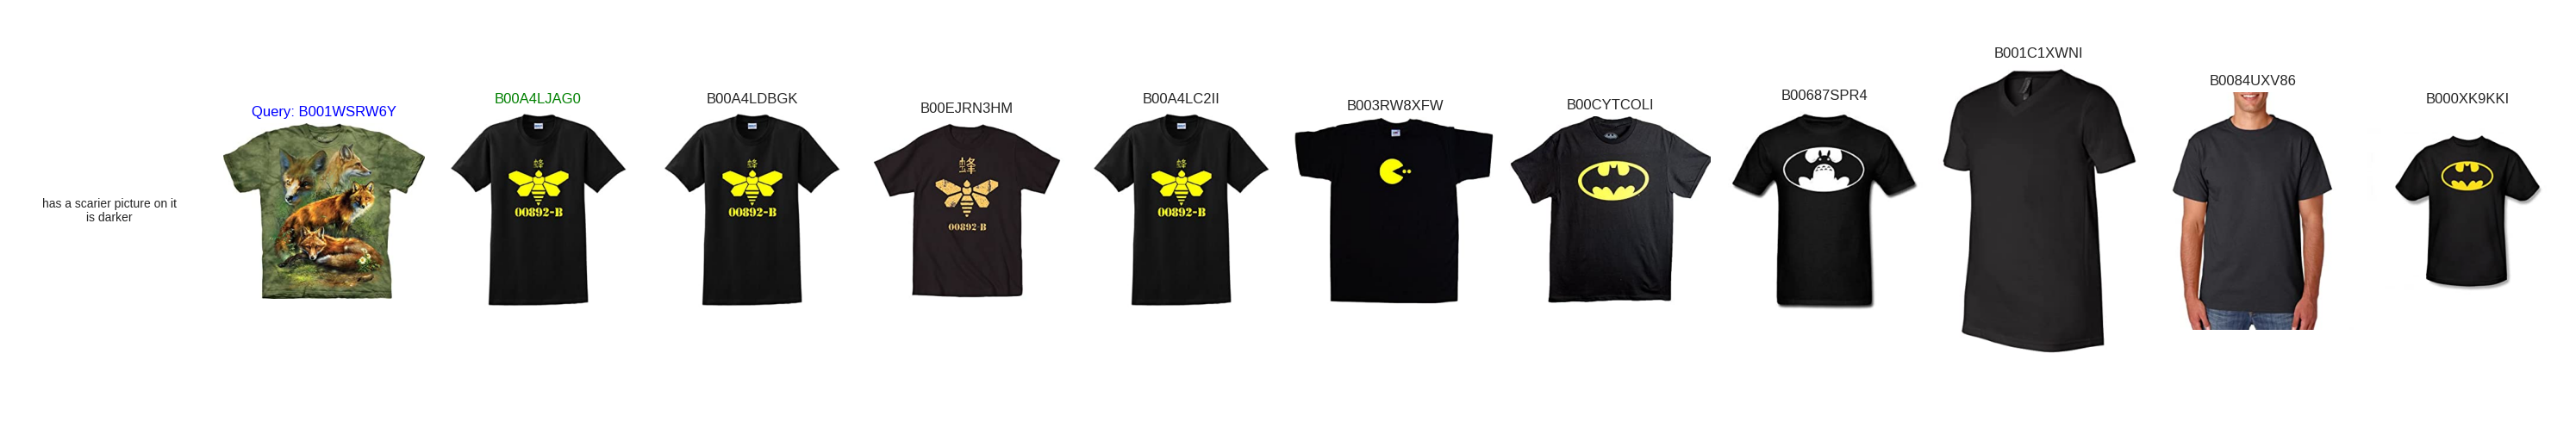

In [41]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1050)

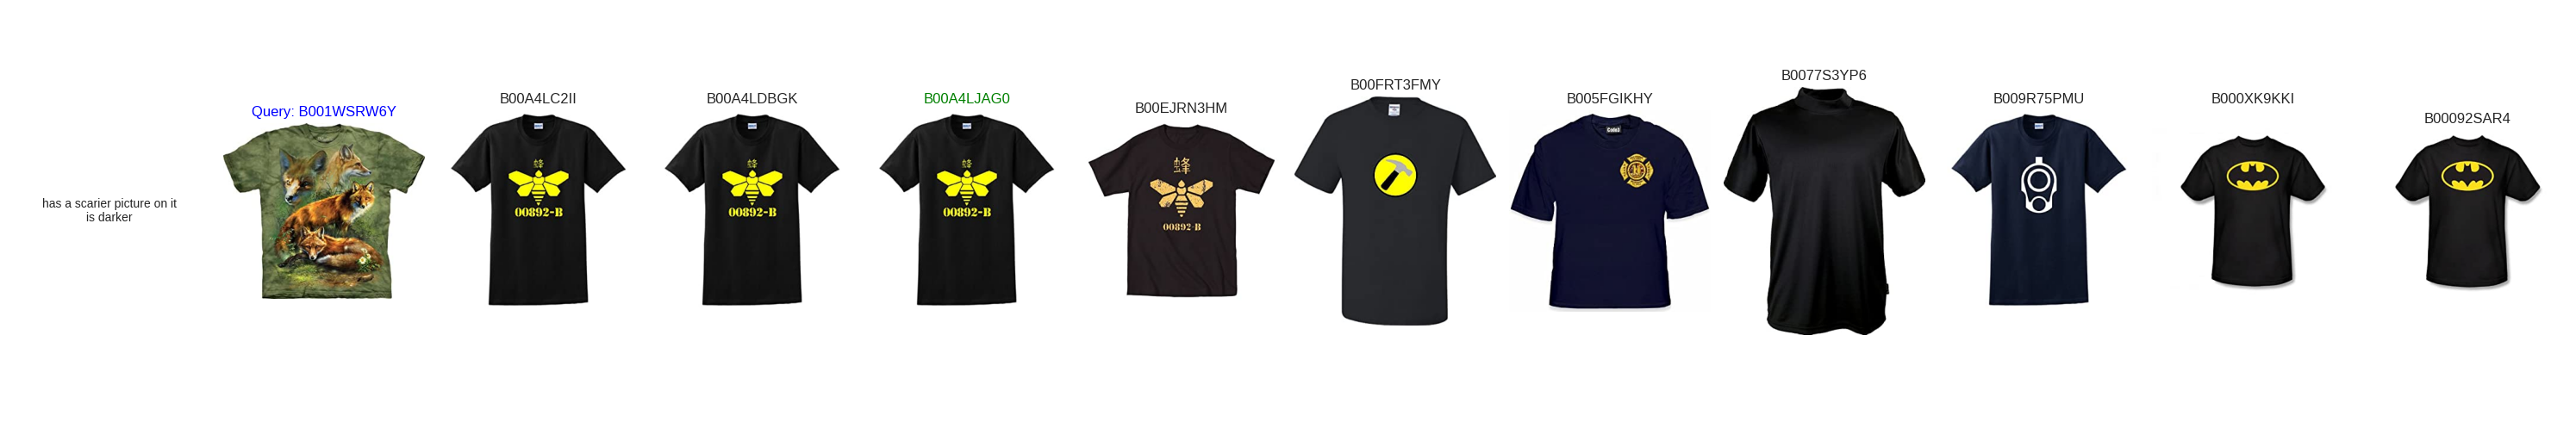

In [42]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1050)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

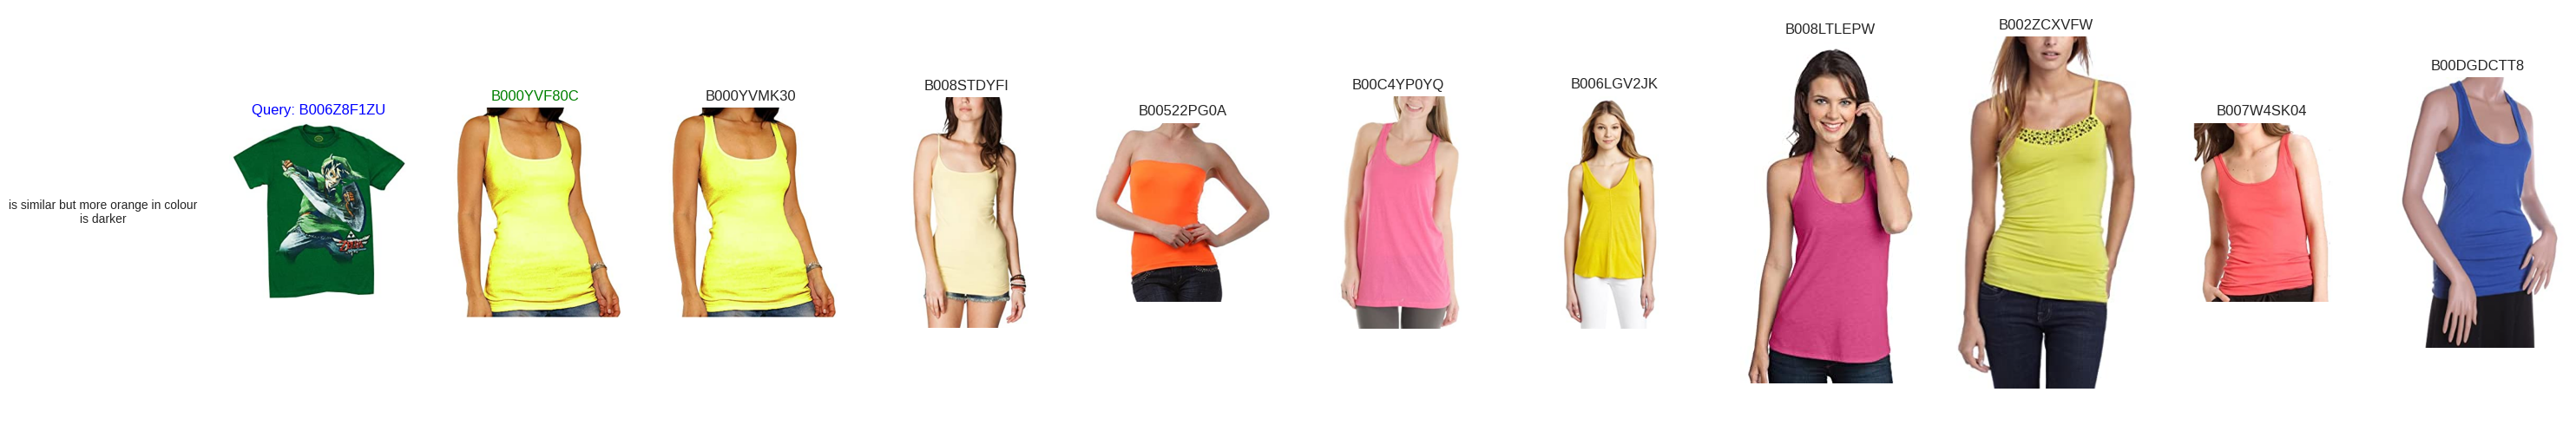

In [43]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=1365)

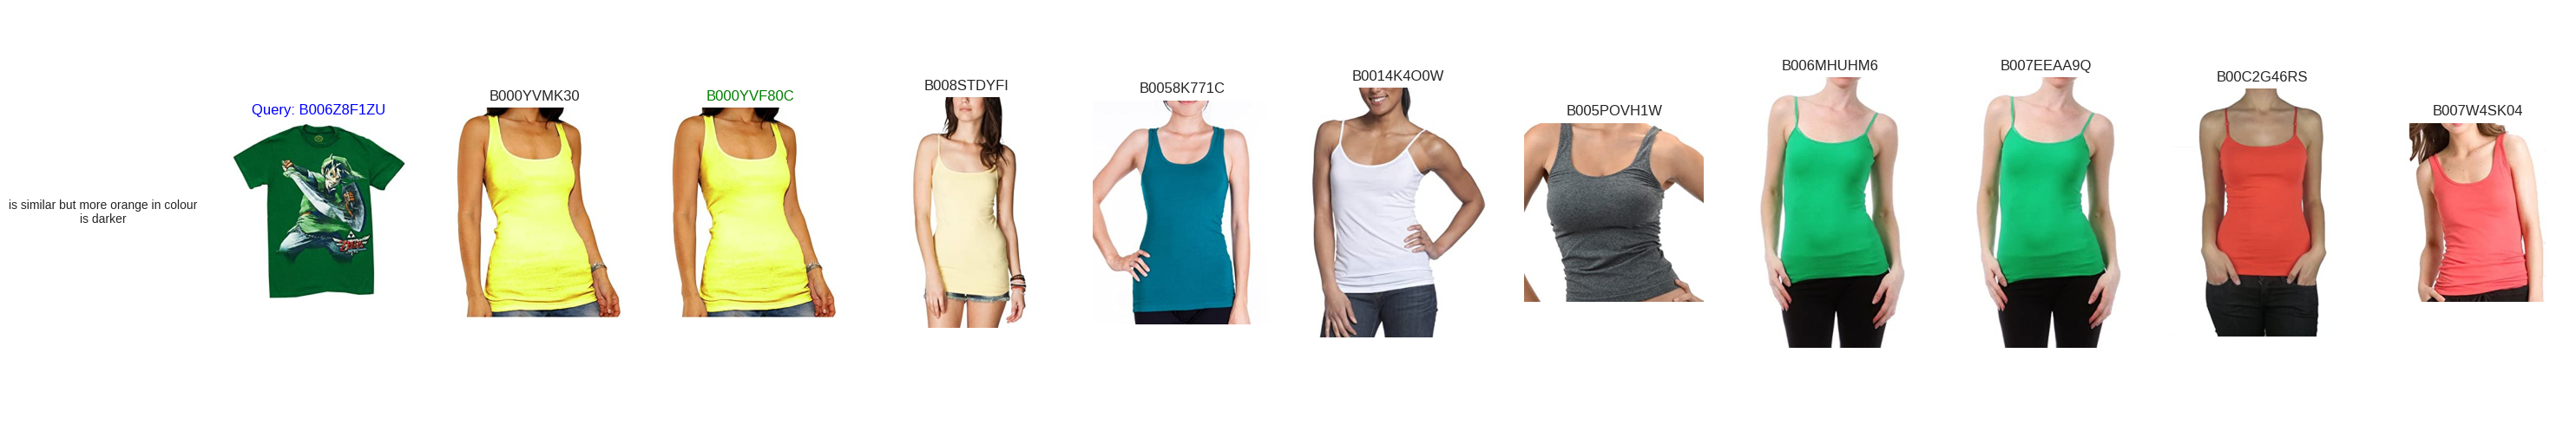

In [44]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=1365)